In [1]:
from __future__ import print_function
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.onnx

import torchvision
from torchvision import transforms, datasets, models

import onnx

import helper

from collections import OrderedDict

import numpy as np
import timeit
import glob
import matplotlib.pyplot as plt
from PIL import Image

## Switching from ND Array > Pytorch Tensor -> ND Array

In [2]:
randomArray = np.random.randn(5, 3)
randomArray

array([[ 0.65802511,  0.31800725, -0.98079151],
       [ 1.62358205,  1.43443971,  1.17879044],
       [-0.47728176,  0.33831738, -0.99730623],
       [ 0.98266145,  0.65994932,  0.73834265],
       [ 1.1194253 , -0.95064827, -0.69634451]])

In [3]:
randomTensor = torch.from_numpy(randomArray)
randomTensor

tensor([[ 0.6580,  0.3180, -0.9808],
        [ 1.6236,  1.4344,  1.1788],
        [-0.4773,  0.3383, -0.9973],
        [ 0.9827,  0.6599,  0.7383],
        [ 1.1194, -0.9506, -0.6963]], dtype=torch.float64)

In [4]:
randomTensor.numpy()

array([[ 0.65802511,  0.31800725, -0.98079151],
       [ 1.62358205,  1.43443971,  1.17879044],
       [-0.47728176,  0.33831738, -0.99730623],
       [ 0.98266145,  0.65994932,  0.73834265],
       [ 1.1194253 , -0.95064827, -0.69634451]])

# Switching from using CPU - GPU


In [5]:
cpu = torch.device('cpu')
cuda = torch.device('cuda')

In [6]:
cuda_0 = torch.device('cuda:0')
cuda_2 = torch.device('cuda:2')

In [15]:
w1 = torch.rand(10000, 10000, device='cpu')
x1 = torch.rand(10000, 10000, device='cpu')

In [16]:
start_cpu = timeit.default_timer()

x1.matmul(w1)

end_cpu = timeit.default_timer()
print('Timelapse: ', end_cpu- start_cpu)

Timelapse:  26.24485985499996


In [17]:
start_gpu = timeit.default_timer()

x1 = x1.cuda()
w1 = w1.cuda()

x1.matmul(w1)

end_gpu = timeit.default_timer()
print('Timelapse: ', end_gpu - start_gpu)

Timelapse:  0.10825658899989321


In [18]:
print('Difference: ', np.round((end_cpu- start_cpu)/(end_gpu - start_gpu), 0),'x faster')

Difference:  242.0 x faster


# Calculate the gradient

In [19]:
# By default, requires_grad is set to False
x = torch.randn(5, 5)
y = torch.randn(5, 5)
z = torch.randn((5, 5), requires_grad=True)

result = x + y
print(result.requires_grad)

second_result = result + z
print(second_result.requires_grad)

False
True


In [23]:
input = Variable(torch.ones(2, 2).cuda(), requires_grad=True)
print("Before: ", input.grad)

output = input.mean()
output.backward()

print("After: ", input.grad)

Before:  None
After:  tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]], device='cuda:0')


#  Object Oriented Programming Style

In [24]:
input_size = 784
hidden_size = [128, 64]
output_size = 10

In [25]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [26]:
oop_model = Network(input_size=input_size, 
                    hidden_size=hidden_size, 
                    output_size=output_size)
oop_model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

By default, weights and bias are automatically filled up

In [27]:
print(oop_model.fc1.weight)
print(oop_model.fc1.bias)

Parameter containing:
tensor([[ 0.0101,  0.0073,  0.0131,  ...,  0.0017, -0.0079,  0.0113],
        [-0.0309,  0.0304, -0.0293,  ...,  0.0342,  0.0025, -0.0324],
        [-0.0202,  0.0244,  0.0018,  ...,  0.0021, -0.0092,  0.0335],
        ...,
        [-0.0014,  0.0119, -0.0326,  ...,  0.0259, -0.0082,  0.0062],
        [ 0.0339,  0.0206, -0.0179,  ...,  0.0306, -0.0193,  0.0007],
        [-0.0129, -0.0127,  0.0133,  ..., -0.0138, -0.0050,  0.0338]],
       requires_grad=True)
Parameter containing:
tensor([-0.0099,  0.0255, -0.0233, -0.0062, -0.0220,  0.0006,  0.0149,  0.0165,
        -0.0190,  0.0165, -0.0108, -0.0192,  0.0281,  0.0216,  0.0234, -0.0356,
         0.0142, -0.0254,  0.0080,  0.0025,  0.0226, -0.0295, -0.0116, -0.0219,
        -0.0044, -0.0129,  0.0125, -0.0112,  0.0022,  0.0168, -0.0196,  0.0250,
        -0.0332,  0.0016,  0.0208,  0.0016,  0.0283,  0.0085, -0.0260, -0.0240,
        -0.0104, -0.0173, -0.0145, -0.0127, -0.0356,  0.0267,  0.0129, -0.0240,
         0.0152

We can also modify the value of these tensors

In [28]:
# Set bias to be zero
oop_model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [29]:
# Set weight into normal distribution with standard deviation of .01
oop_model.fc1.weight.data.normal_(std=.01)

tensor([[-0.0080, -0.0012, -0.0093,  ...,  0.0034, -0.0079,  0.0008],
        [-0.0029,  0.0045,  0.0019,  ...,  0.0166, -0.0020, -0.0117],
        [ 0.0005, -0.0007, -0.0194,  ..., -0.0053,  0.0102, -0.0126],
        ...,
        [-0.0039, -0.0096,  0.0064,  ...,  0.0108, -0.0096,  0.0054],
        [ 0.0110,  0.0167, -0.0016,  ..., -0.0001,  0.0016,  0.0177],
        [ 0.0085, -0.0049,  0.0069,  ...,  0.0055,  0.0053, -0.0028]])

# Sequential Style

In [30]:
sequential_model = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_size[0]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[0], out_features=hidden_size[1]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[1], out_features=output_size),
                                 nn.Softmax(dim=1))

sequential_model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)

# Sequential Style - Alternative

In [31]:
alt_sequential_model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_size[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
    ('relu2', nn.ReLU()),
    ('output', nn.Linear(hidden_size[1], output_size)),
    ('softmax', nn.Softmax(dim=1))
]))

alt_sequential_model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

We can pick up any layer easily like you used to code in Python

In [32]:
print(sequential_model[0])
print(sequential_model[1])

print(oop_model.fc1)
print(oop_model.fc2)

print(alt_sequential_model.fc2)
print(alt_sequential_model.relu1)

Linear(in_features=784, out_features=128, bias=True)
ReLU()
Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=128, out_features=64, bias=True)
ReLU()


# Simple Neural Network - Fashion MNIST

## Define Pre-processing Pipeline

In [41]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

## Prepare Datasets

In [42]:
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Initialize Input Parameters

In [43]:
input_size = 784
output_size = 10
hidden_layers = [512, 256, 128]

## Setup

In [44]:
model = helper.Network(input_size, output_size, hidden_layers)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train Model

In [45]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device, isTransfer=False)

RuntimeError: size mismatch, m1: [1792 x 28], m2: [784 x 512] at /opt/conda/conda-bld/pytorch_1532502421238/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

# Save Model

In [45]:
checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'mymodel.pth')

# Load Model

In [46]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

print(model)

Network(
  (fc): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


# Finetuning by Using Pre-trained Model

In [121]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

d:\programs\anaconda3\envs\deep-learning\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [122]:
data_dir = 'Cat_Dog_data/'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


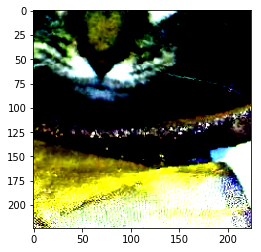

In [130]:
image, label = next(iter(trainloader))
plt.imshow(image[0].numpy().transpose((1, 2, 0)))
print(image[0].shape)

In [81]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device, epochs=1, isTransfer=True)

Device: cuda..  Epoch: 1/1..  Training Loss: 0.278..  Test Loss: 0.167..  Test Accuracy: 0.932
Device: cuda..  Epoch: 1/1..  Training Loss: 0.477..  Test Loss: 0.073..  Test Accuracy: 0.975
Device: cuda..  Epoch: 1/1..  Training Loss: 0.640..  Test Loss: 0.056..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 0.792..  Test Loss: 0.091..  Test Accuracy: 0.969
Device: cuda..  Epoch: 1/1..  Training Loss: 0.969..  Test Loss: 0.050..  Test Accuracy: 0.983
Device: cuda..  Epoch: 1/1..  Training Loss: 1.134..  Test Loss: 0.066..  Test Accuracy: 0.976
Device: cuda..  Epoch: 1/1..  Training Loss: 1.301..  Test Loss: 0.075..  Test Accuracy: 0.975
Device: cuda..  Epoch: 1/1..  Training Loss: 1.391..  Test Loss: 0.054..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 1.529..  Test Loss: 0.055..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 1.651..  Test Loss: 0.056..  Test Accuracy: 0.978
Device: cuda..  Epoch: 1/1..  Training Loss: 1.787

# Convert from Pytorch to another framework by using ONNX

In [171]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

# Export
dummy_input = Variable(torch.randn(1, 784, requires_grad=True))
torch.onnx.export(model, dummy_input, 'first_export.onnx')

#Import 
onnx_model = onnx.load('first_export.onnx')

# Vaidate imported model
onnx.checker.check_model(model)
onnx.helper.printable_graph(model.graph)

AttributeError: 'Network' object has no attribute 'SerializeToString'